# Project 1: Classification
**ECE 219**: Large-Scale Data Mining: Models and Algorithms [Winter 2021]

Prof. Vwani Roychowdhury

UCLA, Department of ECE

(ALL QUESTIONS ARE ANSWERED IN THE REPORT)

#### Questions 9 - 11

### Load 20newsgroups dataset from sklearn

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import GaussianNB
import nltk
import random
from sklearn.datasets import fetch_20newsgroups
import numpy as np
from matplotlib import pyplot as plt
from nltk import pos_tag
from sklearn.metrics import auc
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from statistics import mean

np.random.seed(42)
random.seed(42)

TARGET_MAP = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
}
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']

# load data and group into two categories: “Computer Technology” and “Recreational Activity”
twenty_train = fetch_20newsgroups(
    subset='train', categories=categories, shuffle=True, random_state=None)
twenty_train.target = np.array(
    list(map(lambda label: TARGET_MAP[label], twenty_train.target)))
twenty_test = fetch_20newsgroups(
    subset='test', categories=categories, shuffle=True, random_state=None)
twenty_test.target = np.array(
    list(map(lambda label: TARGET_MAP[label], twenty_test.target)))

### GLoVE embeddings:

Glove embedding of a word is a special 200D vector.
Discussed in: https://nlp.stanford.edu/pubs/glove.pdf


### Load GLoVE embeddings of words from:
http://nlp.stanford.edu/data/glove.6B.zip 

In [3]:
import numpy as np
embeddings_dict = {}
dimension_of_glove = 300
with open("C:/Users/sriva/Desktop/glove.6B/glove.6B.300d.txt", 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [30]:
glove_keys = embeddings_dict.keys()
print(type(glove_keys))
print(len(glove_keys))

<class 'dict_keys'>
400000


In [31]:
print(type(embeddings_dict['computer']))

<class 'numpy.ndarray'>


### A few experimentations on GLoVE embeddings of some words

In [55]:
print(embeddings_dict['run']-embeddings_dict['running'])

[ 1.42960012e-01  8.48399997e-02 -4.75869983e-01  5.96100986e-01
  1.68161005e-01  8.71300101e-02 -2.36621007e-01  1.66180015e-01
  2.76230007e-01 -2.23099947e-01  2.86839008e-01 -5.81900179e-02
 -4.61879015e-01 -5.06300330e-02  2.43402004e-01 -1.04489997e-01
  2.74988711e-01 -1.87640011e-01  2.94189990e-01 -1.35240033e-02
  4.20290008e-02 -5.39059997e-01  9.03999954e-02  1.27328008e-01
  6.43700063e-02 -4.18799818e-02 -1.17139995e-01  6.84499979e-01
 -1.98779985e-01 -1.21578999e-01  1.83562994e-01 -2.28659004e-01
  8.83000195e-02 -1.42190009e-01  2.92520046e-01  4.05573010e-01
 -7.12299943e-02  2.00929984e-01 -1.48670003e-01 -2.29028016e-02
  1.91690028e-01  5.03589988e-01  2.03705996e-01  3.44249964e-01
 -3.83345008e-01 -1.80479996e-02 -6.86845958e-01  1.58500075e-02
 -8.64900053e-02  3.44300047e-02 -3.28969985e-01  1.40429989e-01
  1.20809987e-01  2.44079992e-01  3.04400027e-02  1.25845999e-01
 -9.84800160e-02  1.51560009e-01 -9.62400436e-02  2.15439007e-01
  3.66107196e-01  5.84169

In [107]:
print(embeddings_dict['sportwriters'])

KeyError: 'sportwriters'

In [162]:
aa = embeddings_dict["queen"] - embeddings_dict["king"] - embeddings_dict["wife"] + embeddings_dict["husband"]
print(np.linalg.norm(aa))

6.165036


In [164]:
aa1 = embeddings_dict["queen"] - embeddings_dict["king"]
aa2 = embeddings_dict["wife"] - embeddings_dict["husband"]
print(np.linalg.norm(aa1))
print(np.linalg.norm(aa2))

5.966258
3.1520464


In [4]:
aa = embeddings_dict['queen'] - embeddings_dict['king'] - embeddings_dict['wife'] + embeddings_dict['husband']
bb = embeddings_dict['queen'] - embeddings_dict['king']
cc = embeddings_dict['wife'] - embeddings_dict['husband']
dd = [np.linalg.norm(embeddings_dict['queen']), np.linalg.norm(embeddings_dict['king']), np.linalg.norm(embeddings_dict['wife']), np.linalg.norm(embeddings_dict['husband'])]
print(np.linalg.norm(aa))
print(np.linalg.norm(bb))
print(np.linalg.norm(cc))
print(dd)

6.165036
5.966258
3.1520464
[6.931188, 7.0080056, 6.189922, 5.8665223]


In [14]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity([bb],[cc]))

[[0.20004222]]


In [7]:
print(embeddings_dict['queen'][1:5])
print(embeddings_dict['king'][1:5])
print((embeddings_dict['queen']-embeddings_dict['king'])[1:5])

[ 0.064884 -0.086365  0.51279   0.32543 ]
[-0.34614  0.28144  0.48382  0.59469]
[ 0.411024   -0.367805    0.02897003 -0.26926002]


In [18]:
ee = embeddings_dict['wife'] - embeddings_dict['robot']
ff = embeddings_dict['king'] - embeddings_dict['robot']
gg = embeddings_dict['queen'] - embeddings_dict['robot']
hh = embeddings_dict['husband'] - embeddings_dict['robot']
print(np.linalg.norm(ee))
print(np.linalg.norm(ff))
print(np.linalg.norm(gg))
print(np.linalg.norm(hh))
print("****")
print(np.linalg.norm(embeddings_dict['queen'] - embeddings_dict['king'] - embeddings_dict['wife'] + embeddings_dict['mango']))
print(np.linalg.norm(embeddings_dict['queen'] - embeddings_dict['king'] - embeddings_dict['mango'] + embeddings_dict['husband']))
print(np.linalg.norm(embeddings_dict['queen'] - embeddings_dict['mango'] - embeddings_dict['wife'] + embeddings_dict['husband']))
print(np.linalg.norm(embeddings_dict['mango'] - embeddings_dict['king'] - embeddings_dict['wife'] + embeddings_dict['husband']))

8.92986
9.180818
8.943942
8.602281
****
10.335268
10.564413
9.259597
9.695459


In [16]:
ee = embeddings_dict['wife'] - embeddings_dict['robot']
ff = embeddings_dict['queen'] - embeddings_dict['king']
print(cosine_similarity([ee],[ff]))
ee = embeddings_dict['robot'] - embeddings_dict['husband']
ff = embeddings_dict['queen'] - embeddings_dict['king']
print(cosine_similarity([ee],[ff]))
ee = embeddings_dict['wife'] - embeddings_dict['husband']
ff = embeddings_dict['robot'] - embeddings_dict['king']
print(cosine_similarity([ee],[ff]))
ee = embeddings_dict['wife'] - embeddings_dict['husband']
ff = embeddings_dict['queen'] - embeddings_dict['robot']
print(cosine_similarity([ee],[ff]))

[[0.04176782]]
[[0.02994107]]
[[-0.07393222]]
[[0.20933297]]


In [10]:
ee = embeddings_dict['wife'] - embeddings_dict['mango']
ff = embeddings_dict['king'] - embeddings_dict['mango']
gg = embeddings_dict['queen'] - embeddings_dict['mango']
hh = embeddings_dict['husband'] - embeddings_dict['mango']
print(np.linalg.norm(ee))
print(np.linalg.norm(ff))
print(np.linalg.norm(gg))
print(np.linalg.norm(hh))

8.816896
9.209316
9.087559
8.776013


In [17]:
ee = embeddings_dict['wife'] - embeddings_dict['mango']
ff = embeddings_dict['queen'] - embeddings_dict['king']
print(cosine_similarity([ee],[ff]))
ee = embeddings_dict['mango'] - embeddings_dict['husband']
ff = embeddings_dict['queen'] - embeddings_dict['king']
print(cosine_similarity([ee],[ff]))
ee = embeddings_dict['wife'] - embeddings_dict['husband']
ff = embeddings_dict['mango'] - embeddings_dict['king']
print(cosine_similarity([ee],[ff]))
ee = embeddings_dict['wife'] - embeddings_dict['husband']
ff = embeddings_dict['queen'] - embeddings_dict['mango']
print(cosine_similarity([ee],[ff]))

[[0.06193588]]
[[0.00962397]]
[[0.01283174]]
[[0.11833014]]


### QUESTION 9:
For the binary classification task distinguishing the “Computer Technology” class
and “Recreational Activity” class:

(a) Describe a feature engineering process that uses GLoVE word embeddings to represent each
document. You have to abide by the following rules:

• In each document, there are specific phrases that have more important topical words than
others. They are highlighted by “Keywords: . . . ” or “Subject: . . . ”. Use the average
embedding of these words for each document representation.

• To aggregate these words into a single vector consider normalizing the final vectors

(b) Select a classifier model, train and evaluate it with your GLoVE-based feature


In [36]:
def get_glove (sen):
    #Gives the average of golve representation of words in subject and keyword lines.
    glove_vec = np.zeros((300,))
    sen = sen.lower()
    count = 0 
    for item in sen.split("\n"):
        ww = item.split()
        if  len(ww)>0 and ww[0] in ["subject:","keywords:"]:
            for i in ww:
                if i in glove_keys and i not in stop_words:
                    #print(i)
                    glove_vec = glove_vec + embeddings_dict[i]
                    count = count + 1
                    
    if count == 0:
        return (glove_vec)
    else:
        avg_vec = glove_vec/count
        return (avg_vec/np.linalg.norm(avg_vec))

In [6]:
def plot_roc(figure_name, fpr, tpr):
    # roc curve plot
    fig, ax = plt.subplots()
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label='area under curve = %0.4f' % roc_auc)
    ax.grid(color='0.7', linestyle='--', linewidth=1)
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=15)
    ax.set_ylabel('True Positive Rate', fontsize=15)
    ax.legend(loc="lower right")
    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)
    fig.savefig(figure_name)
def fit_predict_and_plot_roc(figure_name, pipe, train_data, train_label, test_data, test_label):
    # fit, predict and plot roc
    pipe.fit(train_data, train_label)
    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:, 1])
    plot_roc(figure_name, fpr, tpr)

#### Data preprocessing of the GLoVE embeddings

In [33]:
# configure stop words
stop_words = CountVectorizer(stop_words='english').get_stop_words()
def rmv_stp_digits(doc):
    return (word for word in CountVectorizer().build_analyzer()(doc) if word not in stop_words and not word.isdigit())

In [37]:
Xtrain_glove = np.zeros((len(twenty_train.target),300))

for ind in range(len(twenty_train.target)):
    Xtrain_glove[ind] = get_glove(twenty_train.data[ind])
    
print(Xtrain_glove.shape)

#Remove documents that gave 0 mean glove vectors
twenty_train.target = twenty_train.target[~np.all(Xtrain_glove == 0, axis = 1)]
Xtrain_glove = Xtrain_glove[~np.all(Xtrain_glove == 0, axis = 1)]
print(Xtrain_glove.shape)

(4732, 300)
(4476, 300)


In [38]:
#Modifing test set data too:
Xtest_glove = np.zeros((len(twenty_test.target),300))

for ind in range(len(twenty_test.target)):
    Xtest_glove[ind] = get_glove(twenty_test.data[ind])

print(Xtest_glove.shape)

#Remove documents that gave 0 mean glove vectors
twenty_test.target = twenty_test.target[~np.all(Xtest_glove == 0, axis = 1)]
Xtest_glove = Xtest_glove[~np.all(Xtest_glove == 0, axis = 1)]
print(Xtest_glove.shape)

(3150, 300)
(3020, 300)


In [13]:
svd = TruncatedSVD(n_components=100, random_state=0)#100 components chosen
Xtrain_reduced = svd.fit_transform(Xtrain_glove)
print(Xtrain_reduced.shape)
Xtest_reduced = svd.transform(Xtest_glove)
print(Xtest_reduced.shape)


(4476, 100)
(3020, 100)


#### Running a linear SVM for classification

In [14]:
def apply_svm(r_val, train_data, train_labels, test_data, test_labels):
    
    svm_pipline = Pipeline([
        ('clf', LinearSVC(C=r_val)),
    ])
    # roc curve
    fit_predict_and_plot_roc("q9_roc_r{}.png".format(r_val), svm_pipline, train_data,
                             train_labels, test_data, test_labels)
    # confusion matrix
    plot_confusion_matrix(svm_pipline["clf"], test_data, test_labels, display_labels=[
        "computer technology", "recreational activity"])
    plt.savefig('q9_confusion_matrix_r{}.png'.format(r_val))

C:\Users\sriva\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


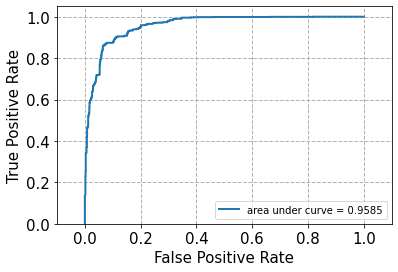

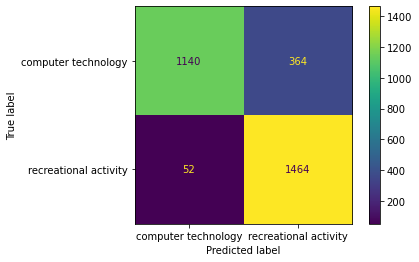

In [15]:
apply_svm(r_val = 1000, train_data = Xtrain_reduced, train_labels = twenty_train.target, test_data = Xtest_reduced, test_labels = twenty_test.target)

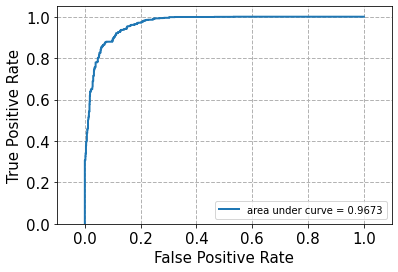

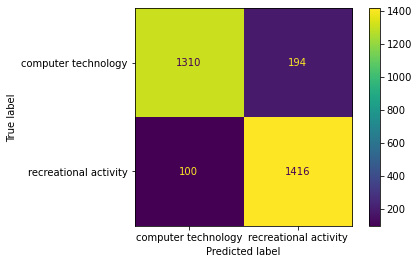

In [16]:
apply_svm(r_val = 0.1, train_data = Xtrain_reduced, train_labels = twenty_train.target, test_data = Xtest_reduced, test_labels = twenty_test.target)

C:\Users\sriva\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


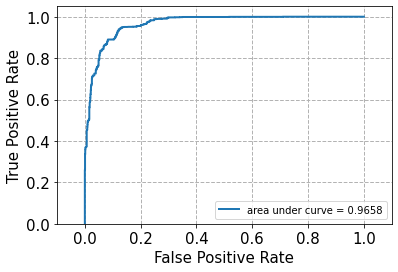

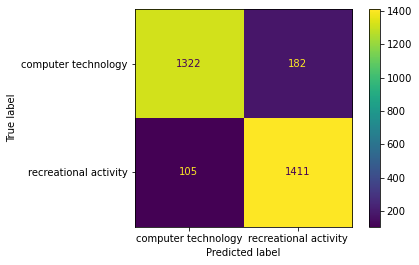

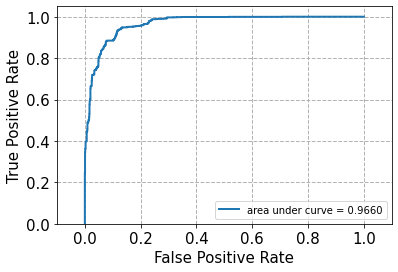

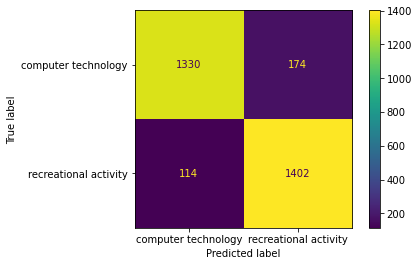

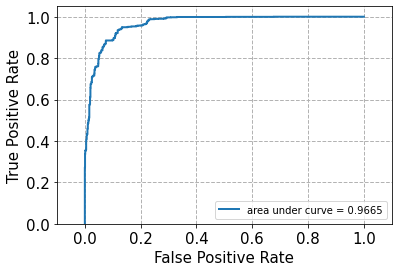

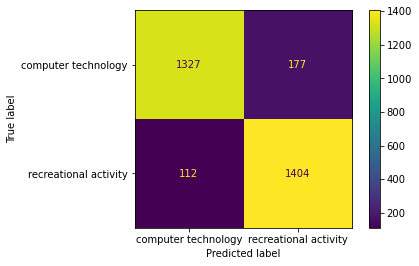

In [17]:
apply_svm(r_val = 100, train_data = Xtrain_reduced, train_labels = twenty_train.target, test_data = Xtest_reduced, test_labels = twenty_test.target)
apply_svm(r_val = 10, train_data = Xtrain_reduced, train_labels = twenty_train.target, test_data = Xtest_reduced, test_labels = twenty_test.target)
apply_svm(r_val = 1, train_data = Xtrain_reduced, train_labels = twenty_train.target, test_data = Xtest_reduced, test_labels = twenty_test.target)

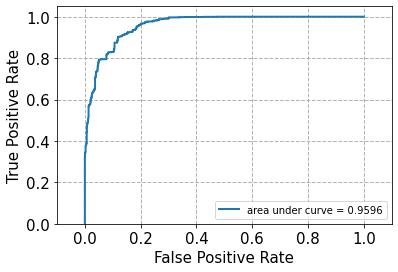

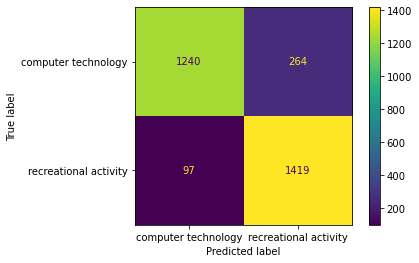

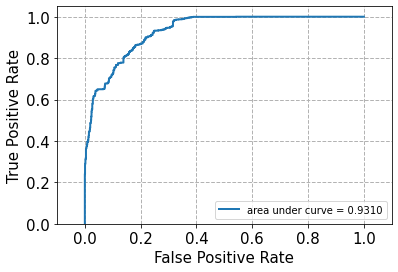

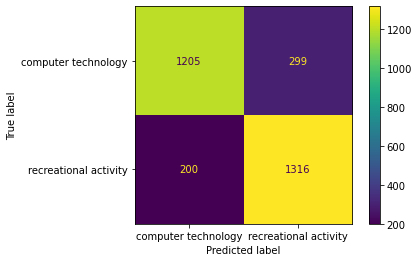

In [18]:
apply_svm(r_val = 0.01, train_data = Xtrain_reduced, train_labels = twenty_train.target, test_data = Xtest_reduced, test_labels = twenty_test.target)
apply_svm(r_val = 0.001, train_data = Xtrain_reduced, train_labels = twenty_train.target, test_data = Xtest_reduced, test_labels = twenty_test.target)

### Question 10

Plot the relationship between the dimension of the pre-trained GLoVE embedding
and the resulting accuracy of the model in the classification task. Describe the observed trend. Is
this trend expected? Why or why not?

In [19]:
def apply_svm_ncomp(n_comp, r_val, Xtrain, train_labels, Xtest, test_labels):
    
    svd = TruncatedSVD(n_components= n_comp, random_state=0)#100 components chosen
    train_data = svd.fit_transform(Xtrain)
    #print(Xtrain_reduced.shape)
    test_data = svd.transform(Xtest)
    #print(Xtest_reduced.shape)
    
    svm_pipline = Pipeline([
        ('clf', LinearSVC(C=r_val)),
    ])
    
    # roc curve
    fit_predict_and_plot_roc("q10_roc_r{}_ncomp{}.png".format(r_val, n_comp), svm_pipline, train_data,
                             train_labels, test_data, test_labels)
    # confusion matrix
    plot_confusion_matrix(svm_pipline["clf"], test_data, test_labels, display_labels=[
        "computer technology", "recreational activity"])
    plt.savefig('q10_confusion_matrix_r{}_ncomp{}.png'.format(r_val, n_comp))

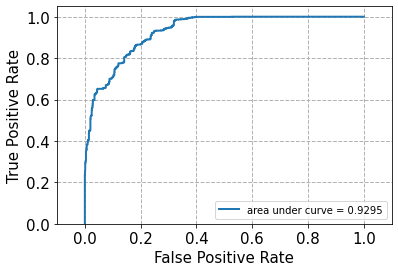

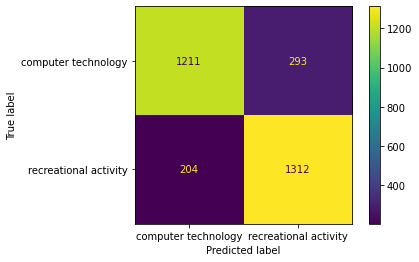

In [20]:
apply_svm_ncomp(n_comp = 50, r_val = 0.001, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)

C:\Users\sriva\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sriva\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
<ipython-input-6-1bc663201e04>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\sriva\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sriva\anaconda3\lib\site-

ValueError: n_components must be < n_features; got 300 >= 300

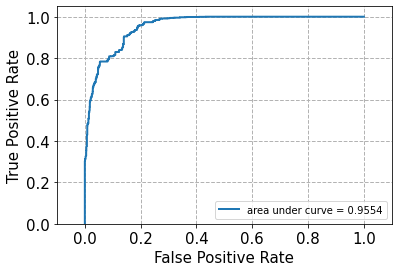

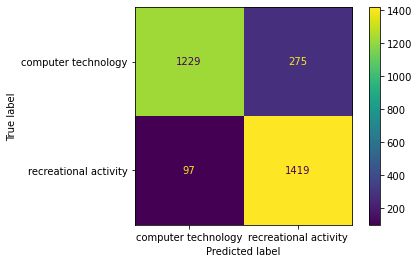

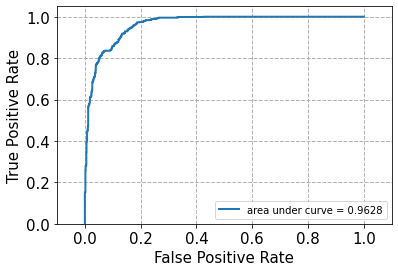

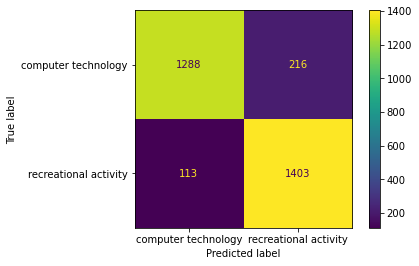

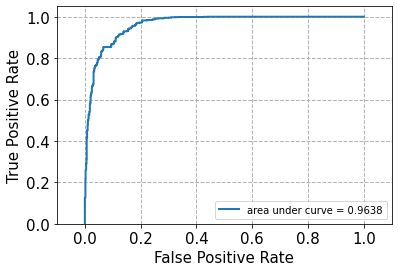

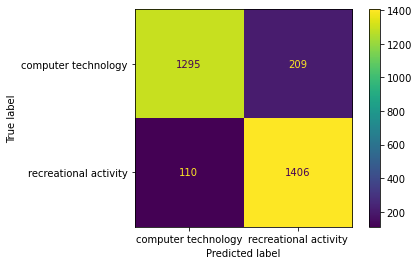

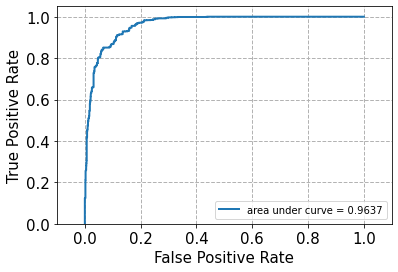

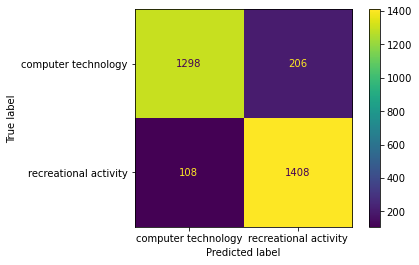

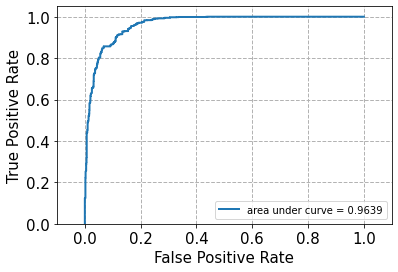

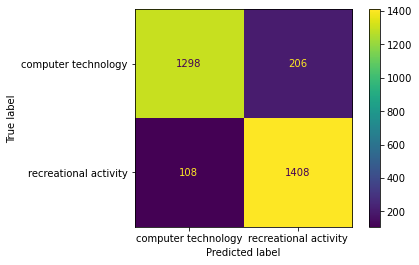

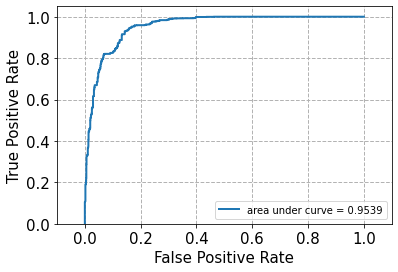

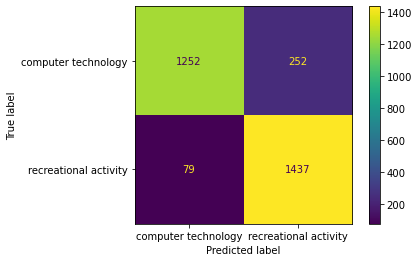

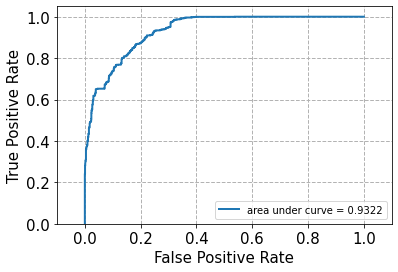

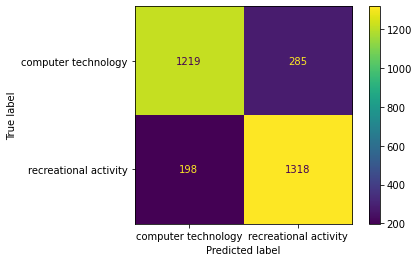

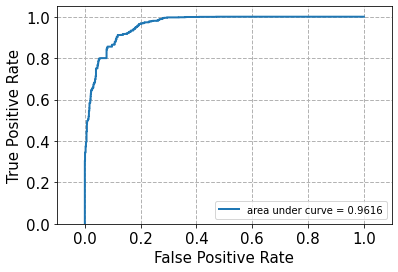

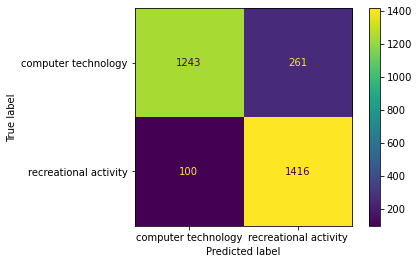

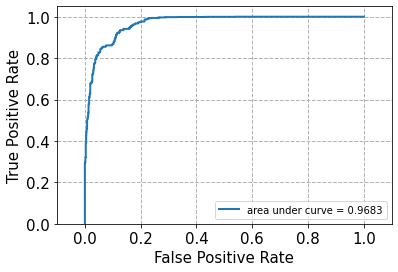

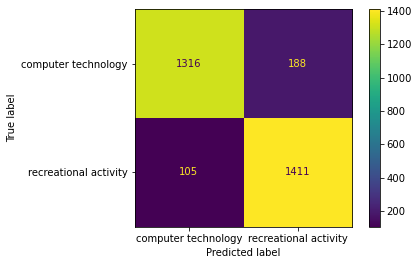

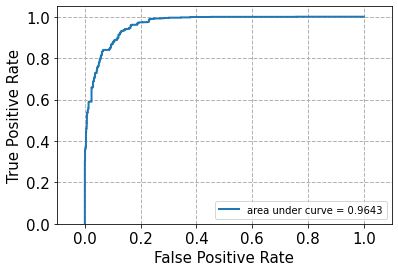

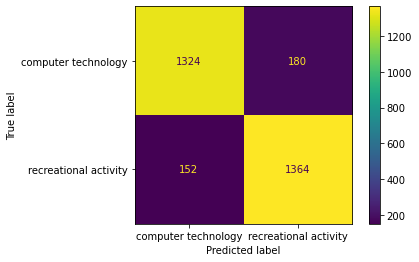

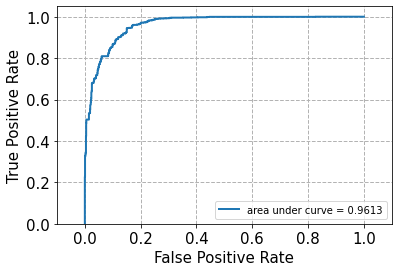

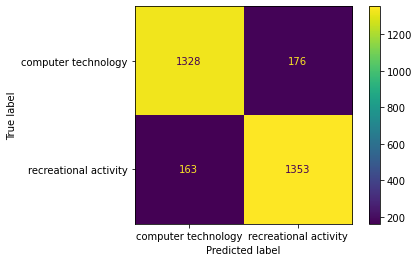

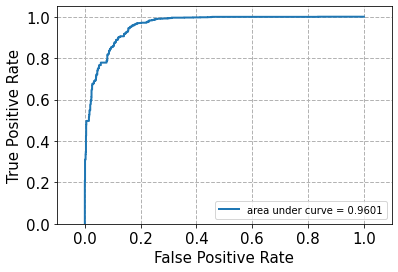

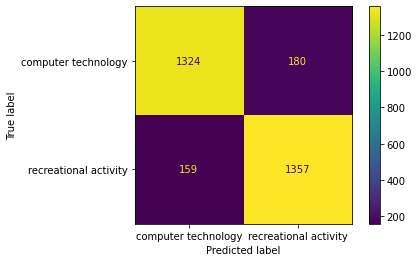

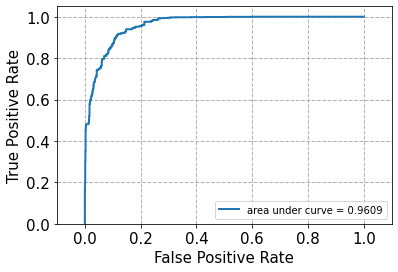

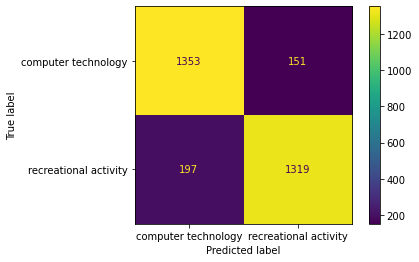

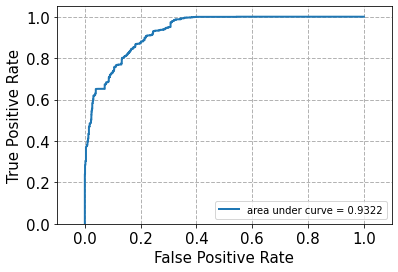

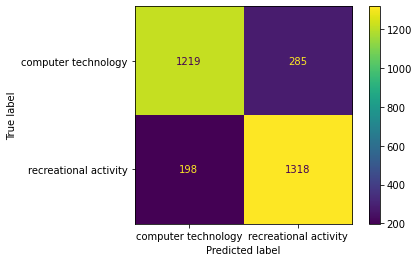

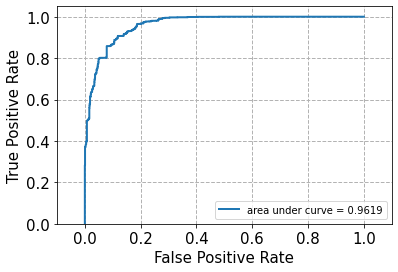

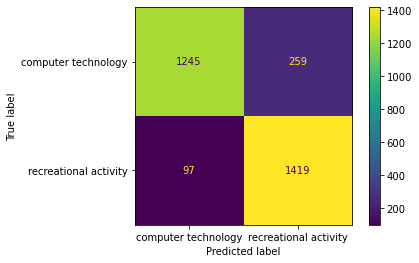

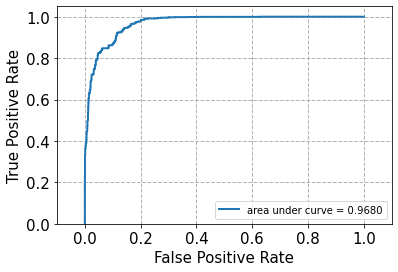

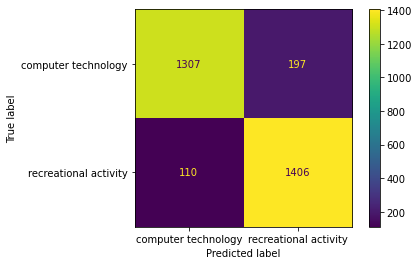

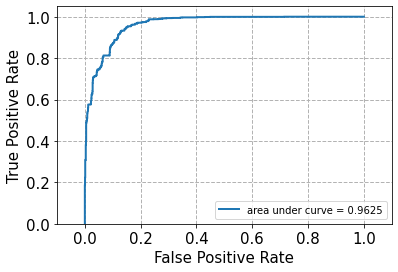

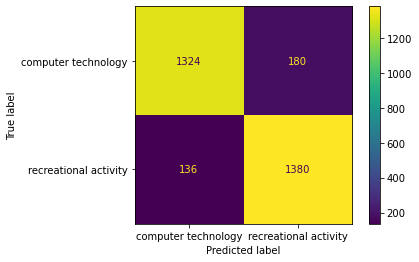

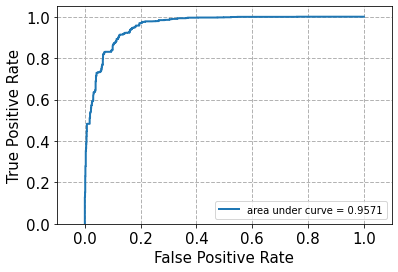

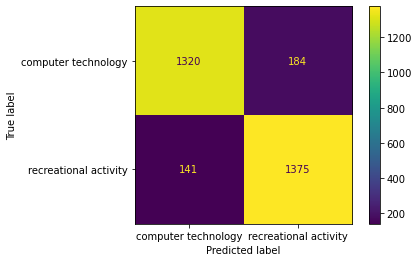

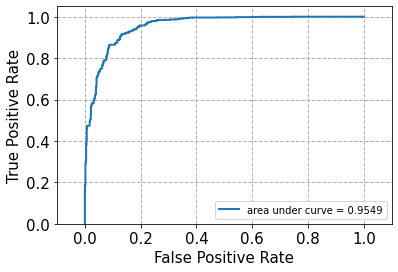

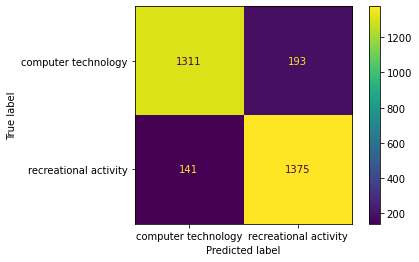

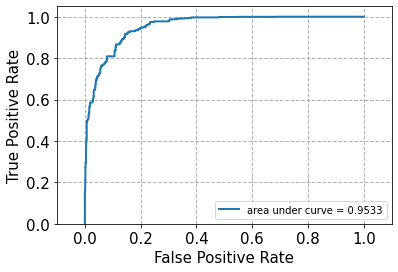

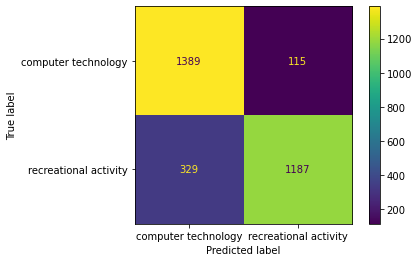

In [21]:
apply_svm_ncomp(n_comp = 50, r_val = 0.01, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 50, r_val = 0.1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 50, r_val = 1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 50, r_val = 10, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 50, r_val = 100, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 50, r_val = 1000, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
#=========================================================================
apply_svm_ncomp(n_comp = 175, r_val = 0.001, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 175, r_val = 0.01, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 175, r_val = 0.1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 175, r_val = 1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 175, r_val = 10, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 175, r_val = 100, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 175, r_val = 1000, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
#=========================================================================
apply_svm_ncomp(n_comp = 250, r_val = 0.001, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 250, r_val = 0.01, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 250, r_val = 0.1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 250, r_val = 1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 250, r_val = 10, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 250, r_val = 100, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 250, r_val = 1000, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
#=========================================================================
apply_svm_ncomp(n_comp = 300, r_val = 0.001, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 300, r_val = 0.01, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 300, r_val = 0.1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 300, r_val = 1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 300, r_val = 10, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 300, r_val = 100, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)
apply_svm_ncomp(n_comp = 300, r_val = 1000, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)

In [39]:
from sklearn import metrics
def svm_ncomp_score(n_comp, r_val, Xtrain, train_labels, Xtest, test_labels):
    
    svd = TruncatedSVD(n_components= n_comp, random_state=0)#100 components chosen
    train_data = svd.fit_transform(Xtrain)
    #print(Xtrain_reduced.shape)
    test_data = svd.transform(Xtest)
    #print(Xtest_reduced.shape)
    
    svm_pipline = Pipeline([
        ('clf', LinearSVC(C=r_val)),
    ])
    
    # roc curve
    fit_predict_and_plot_roc("tq10_roc_r{}_ncomp{}.png".format(r_val, n_comp), svm_pipline, train_data,
                             train_labels, test_data, test_labels)
    # confusion matrix
    plot_confusion_matrix(svm_pipline["clf"], test_data, test_labels, display_labels=[
        "computer technology", "recreational activity"])
    plt.savefig('tq10_confusion_matrix_r{}_ncomp{}.png'.format(r_val, n_comp))
    
    pred_y = svm_pipline["clf"].predict(test_data)
    return([ metrics.accuracy_score(test_labels, pred_y, normalize = True), metrics.recall_score(test_labels, pred_y), metrics.precision_score(test_labels, pred_y), metrics.f1_score(test_labels, pred_y)])


[0.9026490066225166,
 0.9340369393139841,
 0.8795031055900621,
 0.9059500959692898]

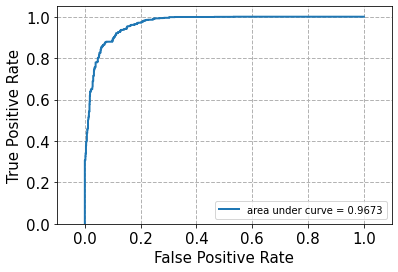

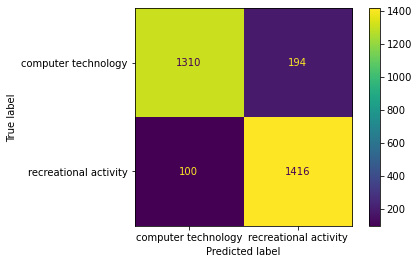

In [23]:
svm_ncomp_score(n_comp = 100, r_val = 0.1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target)

In [40]:
from sklearn import metrics
def svm_score(n_comp, r_val, Xtrain, train_labels, Xtest, test_labels):
    
    svd = TruncatedSVD(n_components= n_comp, random_state=0)#100 components chosen
    train_data = svd.fit_transform(Xtrain)
    #print(Xtrain_reduced.shape)
    test_data = svd.transform(Xtest)
    #print(Xtest_reduced.shape)
    
    #svm_pipline = Pipeline([
        #('clf', LinearSVC(C=r_val)),
    #])
    
    clf = LinearSVC(C=r_val).fit(train_data, train_labels)
    
    # roc curve
    #fit_predict_and_plot_roc("tq10_roc_r{}_ncomp{}.png".format(r_val, n_comp), svm_pipline, train_data,
                             #train_labels, test_data, test_labels)
    # confusion matrix
    #plot_confusion_matrix(svm_pipline["clf"], test_data, test_labels, display_labels=[
        #"computer technology", "recreational activity"])
    #plt.savefig('tq10_confusion_matrix_r{}_ncomp{}.png'.format(r_val, n_comp))
    
    pred_y = clf.predict(test_data)
    acc_score =  metrics.accuracy_score(test_labels, pred_y, normalize = True)
    #return([ metrics.accuracy_score(test_labels, pred_y, normalize = True), metrics.recall_score(test_labels, pred_y), metrics.precision_score(test_labels, pred_y), metrics.f1_score(test_labels, pred_y)])
    return acc_score
    

In [25]:
ncomp_list = np.arange(10,300,10)
acc_list = []
for num in ncomp_list:
    acc_list.append(svm_score(n_comp = num, r_val = 0.1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target))

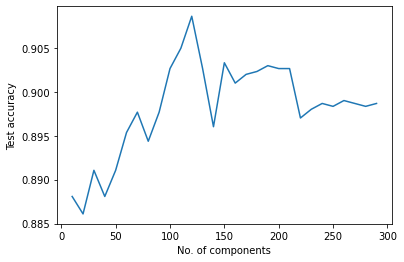

In [26]:
plt.plot(ncomp_list, acc_list)#Test accuracy for r_val = 0. 1
plt.xlabel('No. of components')
plt.ylabel('Test accuracy')
plt.savefig('q11.png')

In [46]:
ncomp_list = np.arange(10,300,5)
acc_listr01 = []
acc_listr1 = []
acc_listr10 = []
for num in ncomp_list:
    acc_listr01.append(svm_score(n_comp = num, r_val = 0.1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target))
for num in ncomp_list:
    acc_listr1.append(svm_score(n_comp = num, r_val = 1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target))
for num in ncomp_list:
    acc_listr10.append(svm_score(n_comp = num, r_val = 10, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target))
#plt.plot(ncomp_list, acc_list)#Test accuracy for r_val = 0. 1
#plt.xlabel('No. of components')
#plt.ylabel('Test accuracy')
#plt.savefig('q11_r{}.png'.format(r_val))

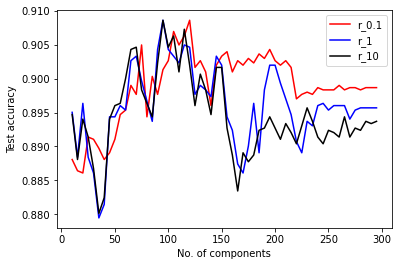

In [47]:
plt.plot(ncomp_list, acc_listr01, 'r-',label = 'r_0.1')
plt.plot(ncomp_list, acc_listr1, 'b-',label = 'r_1')
plt.plot(ncomp_list, acc_listr10, 'k-',label = 'r_10')
plt.legend()
plt.xlabel('No. of components')
plt.ylabel('Test accuracy')
plt.savefig('q11_allr.png')

In [48]:
ncomp_list = np.arange(10,300,1)
acc_listr01a = []
acc_listr1a = []
acc_listr10a = []
for num in ncomp_list:
    acc_listr01a.append(svm_score(n_comp = num, r_val = 0.1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target))
for num in ncomp_list:
    acc_listr1a.append(svm_score(n_comp = num, r_val = 1, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target))
for num in ncomp_list:
    acc_listr10a.append(svm_score(n_comp = num, r_val = 10, Xtrain = Xtrain_glove, train_labels = twenty_train.target, Xtest = Xtest_glove, test_labels = twenty_test.target))

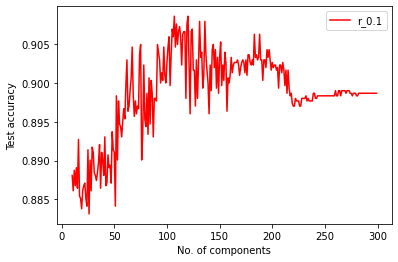

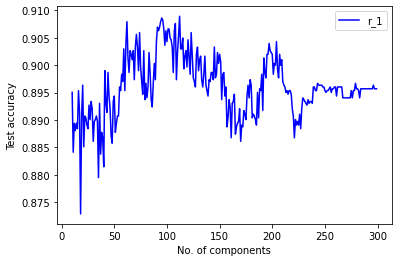

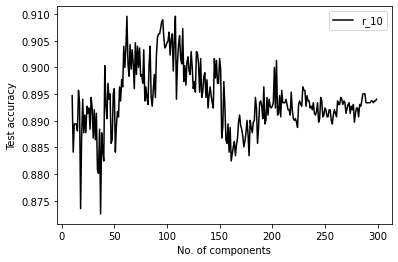

In [53]:
fig = plt.figure()
plt.plot(ncomp_list, acc_listr01a, 'r-',label = 'r_0.1')
plt.legend()
plt.xlabel('No. of components')
plt.ylabel('Test accuracy')
plt.savefig('q10_r_0.1.png')
fig = plt.figure()
plt.plot(ncomp_list, acc_listr1a, 'b-',label = 'r_1')
plt.legend()
plt.xlabel('No. of components')
plt.ylabel('Test accuracy')
plt.savefig('q10_r_1.png')
fig = plt.figure()
plt.plot(ncomp_list, acc_listr10a, 'k-',label = 'r_10')
plt.legend()
plt.xlabel('No. of components')
plt.ylabel('Test accuracy')
plt.savefig('q10_r_10.png')

### Question 11:

Visualize the set of normalized GLoVE-based embeddings of the documents with their labels
in a 2D plane using the UMAP library. Similarly generate a set of normalized random vectors
of the same dimension as GLoVE and visualize these in a 2D plane with UMAP.

Compare and contrast the two visualizations. Are there clusters formed in either
or both of the plots?

In [27]:
#11
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [28]:
import umap
reducer = umap.UMAP()
scaled_data = StandardScaler().fit_transform(Xtrain_glove)
print(scaled_data.shape)
embedding = reducer.fit_transform(scaled_data)
print(embedding.shape)

C:\Users\sriva\anaconda3\lib\site-packages\umap\__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


(4476, 300)
(4476, 2)


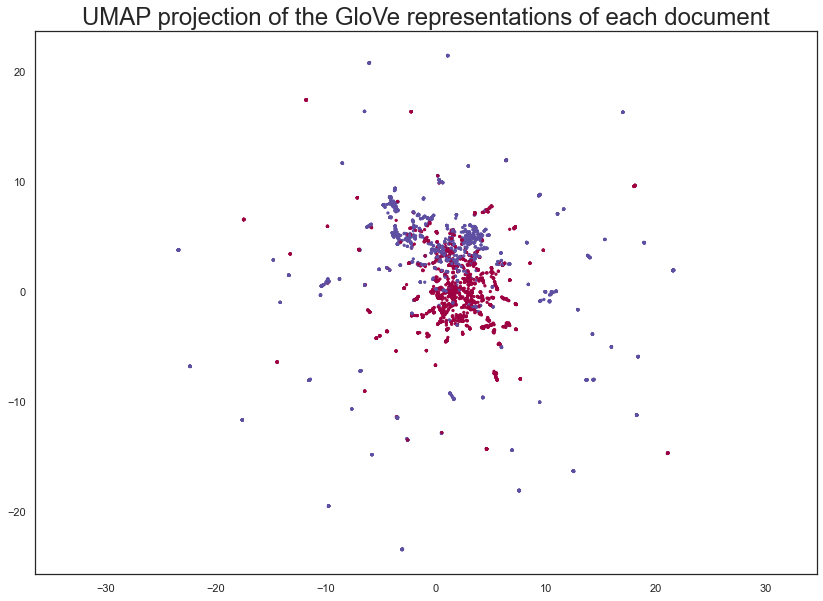

In [29]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=twenty_train.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=[0,1])
plt.title('UMAP projection of the GloVe representations of each document', fontsize=24);
plt.savefig('q12_data.png')

(4476, 2)


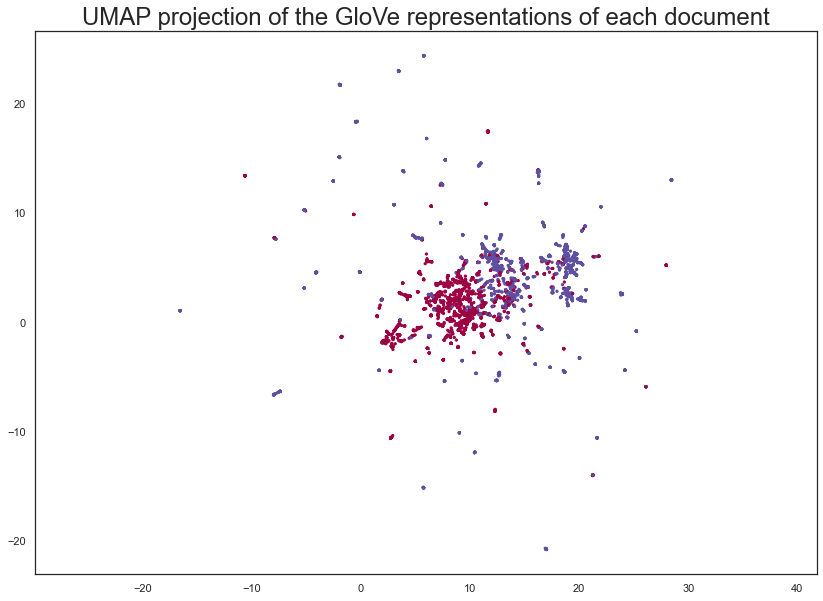

In [30]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(Xtrain_glove)
print(embedding.shape)
plt.scatter(embedding[:, 0], embedding[:, 1], c=twenty_train.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=[0,1])
plt.title('UMAP projection of the GloVe representations of each document', fontsize=24);
plt.savefig('q12_data_noscaling.png')

In [31]:
from random import gauss

def make_rand_vector(dims):
    vec = [gauss(0, 1) for i in range(dims)]
    mag = sum(x**2 for x in vec) ** .5
    return [x/mag for x in vec]

In [32]:
random_vects = np.zeros((4476, 300))
for i in range(4476):
    random_vects[i] = make_rand_vector(300)

(4476, 300)
(4476, 2)


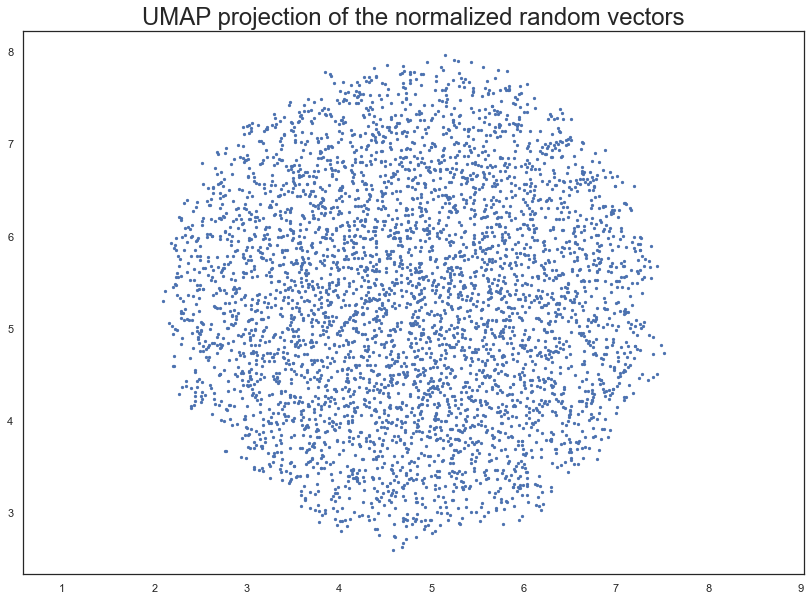

In [33]:
reducer = umap.UMAP()
scaled_data = StandardScaler().fit_transform(random_vects)
print(scaled_data.shape)
embedding = reducer.fit_transform(scaled_data)
print(embedding.shape)
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=[0,1])
plt.title('UMAP projection of the normalized random vectors', fontsize=24);
plt.savefig('q12_data_random.png')

(4476, 2)


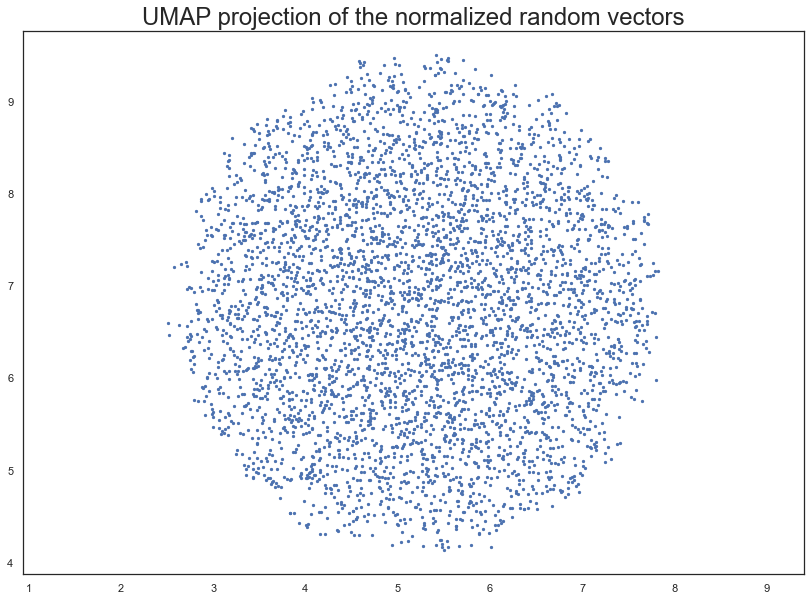

In [34]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(random_vects)
print(embedding.shape)
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=[0,1])
plt.title('UMAP projection of the normalized random vectors', fontsize=24);
plt.savefig('q12_data_random_Noscaling.png')

In [44]:
#DO NOT RUN
sen = twenty_train.data[1294]
print(sen)


Subject: Best Sportwriters...
From: csc2imd@cabell.vcu.edu (Ian M. Derby)
Expires: Sat, 1 May 1993 04:00:00 GMT
Organization: Virginia Commonwealth University
Keywords: Sportswriters
Summary: Sportswriters
Lines: 19


Since someone brought up sports radio, howabout sportswriting???

(Anyone give an opinion) 

Which city do you think has the best sports coverage in terms of
print media? 

(these are general questions) 

Is the Washington Post better than the Philadelphia Inquier or the NY
Times?  

Howabout the Philadelphia Daily News compared to the New York Daily
News?  


Do you notice papers being subjective or objective to the home team?




In [92]:
#Extracting subject and keywords
sen = twenty_train.data[1294].lower()
for item in sen.split("\n"):
    ww = item.split()
    if  len(ww)>0 and ww[0] in ["subject:","keywords:"]:
        for i in ww:
            if i in glove_keys and i not in stop_words:
                print(i)
                aa = embeddings_dict[i]

best
sportswriters


In [101]:
print(max(get_glove(twenty_train.data[1294]) - 0.5* (embeddings_dict["best"] + embeddings_dict["sportswriters"])))
get_glove(twenty_train.data[1294]) - 0.5*(embeddings_dict["best"] + embeddings_dict["sportswriters"])

2.9802322387695312e-08


array([ 0.00000000e+00,  1.49011612e-08,  0.00000000e+00,  0.00000000e+00,
       -7.45058060e-09,  7.45058060e-09,  3.72529030e-09,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.86264515e-09, -3.72529030e-09, -5.58793545e-09,  7.45058060e-09,
        0.00000000e+00, -7.45058060e-09,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.72529030e-09,  1.49011612e-08,
        0.00000000e+00,  0.00000000e+00,  1.86264515e-09,  0.00000000e+00,
       -1.49011612e-08, -5.35510480e-09, -1.49011612e-08, -7.45058060e-09,
        0.00000000e+00, -1.86264515e-09, -2.98023224e-08,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.61934474e-10,  0.00000000e+00,
       -1.86264515e-09, -1.49011612e-08, -6.51925802e-09,  1.11758709e-08,
       -2.32830644e-09, -1.49011612e-08,  0.00000000e+00,  7.45058060e-09,
        0.00000000e+00,  3.72529030e-09,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [95]:
print(max(get_glove(twenty_train.data[1294]) - (embeddings_dict["best"] + embeddings_dict["sportswriters"])))
get_glove(twenty_train.data[1294]) - (embeddings_dict["best"] + embeddings_dict["sportswriters"])

best
sportswriters
5.960464477539063e-08
best
sportswriters


array([ 0.00000000e+00,  2.98023224e-08,  0.00000000e+00,  0.00000000e+00,
       -1.49011612e-08,  1.49011612e-08,  7.45058060e-09,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.72529030e-09, -7.45058060e-09, -1.11758709e-08,  1.49011612e-08,
        0.00000000e+00, -1.49011612e-08,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  7.45058060e-09,  2.98023224e-08,
        0.00000000e+00,  0.00000000e+00,  3.72529030e-09,  0.00000000e+00,
       -2.98023224e-08, -1.07102096e-08, -2.98023224e-08, -1.49011612e-08,
        0.00000000e+00, -3.72529030e-09, -5.96046448e-08,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.23868948e-10,  0.00000000e+00,
       -3.72529030e-09, -2.98023224e-08, -1.30385160e-08,  2.23517418e-08,
       -4.65661287e-09, -2.98023224e-08,  0.00000000e+00,  1.49011612e-08,
        0.00000000e+00,  7.45058060e-09,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [55]:
print(embeddings_dict['run']-embeddings_dict['running'])

[ 1.42960012e-01  8.48399997e-02 -4.75869983e-01  5.96100986e-01
  1.68161005e-01  8.71300101e-02 -2.36621007e-01  1.66180015e-01
  2.76230007e-01 -2.23099947e-01  2.86839008e-01 -5.81900179e-02
 -4.61879015e-01 -5.06300330e-02  2.43402004e-01 -1.04489997e-01
  2.74988711e-01 -1.87640011e-01  2.94189990e-01 -1.35240033e-02
  4.20290008e-02 -5.39059997e-01  9.03999954e-02  1.27328008e-01
  6.43700063e-02 -4.18799818e-02 -1.17139995e-01  6.84499979e-01
 -1.98779985e-01 -1.21578999e-01  1.83562994e-01 -2.28659004e-01
  8.83000195e-02 -1.42190009e-01  2.92520046e-01  4.05573010e-01
 -7.12299943e-02  2.00929984e-01 -1.48670003e-01 -2.29028016e-02
  1.91690028e-01  5.03589988e-01  2.03705996e-01  3.44249964e-01
 -3.83345008e-01 -1.80479996e-02 -6.86845958e-01  1.58500075e-02
 -8.64900053e-02  3.44300047e-02 -3.28969985e-01  1.40429989e-01
  1.20809987e-01  2.44079992e-01  3.04400027e-02  1.25845999e-01
 -9.84800160e-02  1.51560009e-01 -9.62400436e-02  2.15439007e-01
  3.66107196e-01  5.84169

In [107]:
print(embeddings_dict['sportwriters'])

KeyError: 'sportwriters'

In [162]:
aa = embeddings_dict["queen"] - embeddings_dict["king"] - embeddings_dict["wife"] + embeddings_dict["husband"]
print(np.linalg.norm(aa))

6.165036


In [164]:
aa1 = embeddings_dict["queen"] - embeddings_dict["king"]
aa2 = embeddings_dict["wife"] - embeddings_dict["husband"]
print(np.linalg.norm(aa1))
print(np.linalg.norm(aa2))

5.966258
3.1520464


In [4]:
aa = embeddings_dict['queen'] - embeddings_dict['king'] - embeddings_dict['wife'] + embeddings_dict['husband']
bb = embeddings_dict['queen'] - embeddings_dict['king']
cc = embeddings_dict['wife'] - embeddings_dict['husband']
dd = [np.linalg.norm(embeddings_dict['queen']), np.linalg.norm(embeddings_dict['king']), np.linalg.norm(embeddings_dict['wife']), np.linalg.norm(embeddings_dict['husband'])]
print(np.linalg.norm(aa))
print(np.linalg.norm(bb))
print(np.linalg.norm(cc))
print(dd)

6.165036
5.966258
3.1520464
[6.931188, 7.0080056, 6.189922, 5.8665223]


In [14]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity([bb],[cc]))

[[0.20004222]]


In [7]:
print(embeddings_dict['queen'][1:5])
print(embeddings_dict['king'][1:5])
print((embeddings_dict['queen']-embeddings_dict['king'])[1:5])

[ 0.064884 -0.086365  0.51279   0.32543 ]
[-0.34614  0.28144  0.48382  0.59469]
[ 0.411024   -0.367805    0.02897003 -0.26926002]


In [18]:
ee = embeddings_dict['wife'] - embeddings_dict['robot']
ff = embeddings_dict['king'] - embeddings_dict['robot']
gg = embeddings_dict['queen'] - embeddings_dict['robot']
hh = embeddings_dict['husband'] - embeddings_dict['robot']
print(np.linalg.norm(ee))
print(np.linalg.norm(ff))
print(np.linalg.norm(gg))
print(np.linalg.norm(hh))
print("****")
print(np.linalg.norm(embeddings_dict['queen'] - embeddings_dict['king'] - embeddings_dict['wife'] + embeddings_dict['mango']))
print(np.linalg.norm(embeddings_dict['queen'] - embeddings_dict['king'] - embeddings_dict['mango'] + embeddings_dict['husband']))
print(np.linalg.norm(embeddings_dict['queen'] - embeddings_dict['mango'] - embeddings_dict['wife'] + embeddings_dict['husband']))
print(np.linalg.norm(embeddings_dict['mango'] - embeddings_dict['king'] - embeddings_dict['wife'] + embeddings_dict['husband']))

8.92986
9.180818
8.943942
8.602281
****
10.335268
10.564413
9.259597
9.695459


In [16]:
ee = embeddings_dict['wife'] - embeddings_dict['robot']
ff = embeddings_dict['queen'] - embeddings_dict['king']
print(cosine_similarity([ee],[ff]))
ee = embeddings_dict['robot'] - embeddings_dict['husband']
ff = embeddings_dict['queen'] - embeddings_dict['king']
print(cosine_similarity([ee],[ff]))
ee = embeddings_dict['wife'] - embeddings_dict['husband']
ff = embeddings_dict['robot'] - embeddings_dict['king']
print(cosine_similarity([ee],[ff]))
ee = embeddings_dict['wife'] - embeddings_dict['husband']
ff = embeddings_dict['queen'] - embeddings_dict['robot']
print(cosine_similarity([ee],[ff]))

[[0.04176782]]
[[0.02994107]]
[[-0.07393222]]
[[0.20933297]]


In [10]:
ee = embeddings_dict['wife'] - embeddings_dict['mango']
ff = embeddings_dict['king'] - embeddings_dict['mango']
gg = embeddings_dict['queen'] - embeddings_dict['mango']
hh = embeddings_dict['husband'] - embeddings_dict['mango']
print(np.linalg.norm(ee))
print(np.linalg.norm(ff))
print(np.linalg.norm(gg))
print(np.linalg.norm(hh))

8.816896
9.209316
9.087559
8.776013


In [17]:
ee = embeddings_dict['wife'] - embeddings_dict['mango']
ff = embeddings_dict['queen'] - embeddings_dict['king']
print(cosine_similarity([ee],[ff]))
ee = embeddings_dict['mango'] - embeddings_dict['husband']
ff = embeddings_dict['queen'] - embeddings_dict['king']
print(cosine_similarity([ee],[ff]))
ee = embeddings_dict['wife'] - embeddings_dict['husband']
ff = embeddings_dict['mango'] - embeddings_dict['king']
print(cosine_similarity([ee],[ff]))
ee = embeddings_dict['wife'] - embeddings_dict['husband']
ff = embeddings_dict['queen'] - embeddings_dict['mango']
print(cosine_similarity([ee],[ff]))

[[0.06193588]]
[[0.00962397]]
[[0.01283174]]
[[0.11833014]]


In [13]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity([ee],[ff]))

[[0.6570355]]


In [29]:
embeddings_dict['flying']

array([ 0.074134 , -0.15557  , -0.2613   , -0.054718 , -0.43474  ,
        0.15724  , -0.21676  ,  0.56309  , -0.035585 , -1.4301   ,
        0.57792  , -0.060208 ,  0.17675  , -0.54063  ,  0.064847 ,
        0.3963   ,  0.58421  ,  0.596    , -0.19855  ,  0.28937  ,
        0.20734  ,  0.38752  ,  0.39771  ,  0.16944  ,  0.11844  ,
       -0.15951  , -0.29398  , -0.16161  , -0.32398  , -0.029375 ,
       -0.047859 , -0.51325  , -0.32063  , -0.23683  , -0.57738  ,
       -0.24104  , -0.76349  ,  0.11843  , -0.15287  ,  0.61877  ,
       -0.62492  , -0.23273  , -0.3713   , -0.080582 ,  0.069954 ,
       -0.26285  ,  0.52917  ,  0.33961  ,  0.87228  , -0.56875  ,
        0.057404 , -0.48028  , -0.13853  ,  0.22805  , -0.58788  ,
        0.069576 , -0.23184  ,  0.088903 ,  0.26654  ,  0.13374  ,
       -0.14052  , -0.49536  ,  0.51153  , -0.26833  ,  0.17684  ,
       -0.11237  ,  0.0398   ,  0.28223  ,  0.16287  , -0.099257 ,
       -0.27175  ,  0.28346  , -0.19534  , -0.040375 , -0.0412